# Sentiment analysis using Stacking of three submodels: LSTM, Bidirectional LSTM, Feed forward neural networks

In [1]:
# importing certain libraries that shall be usefull for reading and excecuting the code
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer 

In [2]:
sentiments = pd.read_csv('https://raw.githubusercontent.com/dwipddalal/Sentiment_Analysis_using_Ensemble_Learning/main/dataset/sentiment_labels.txt', delimiter='|')
sentiments.head()
# this is the dataset of sentiment values corresponding to the phrase id. 

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [3]:
# this is dataset of phrases 
dataset_phrases = pd.read_csv('https://raw.githubusercontent.com/dwipddalal/Sentiment_Analysis_using_Ensemble_Learning/main/dataset/dictionary.txt',delimiter='|')

# since for getting a good look of overall dataset is important so to put phrase and there sentiment values in a single column
# the phrase in dataset_phrase are jumbled so for concating two dataset that is dataset_phrase and sentiments it is necessary to make the phrase id column of both in same order so we shall sort the dataset_phrase
dataset_phrases.sort_values('0',inplace = True)
dataset_phrases.set_index('0', inplace=True)
dataset_phrases.head()

,!
0,
1,'
2,' (
3,' ( the cockettes
4,' ( the cockettes )
5,' ( the cockettes ) provides a window into a s...


In [4]:
df = pd.concat([dataset_phrases,sentiments], axis=1)
df.head()
df.shape
df.tail()

,!,phrase ids,sentiment values
239227,your standard Hollywood bio-pic,239227,0.36111
239228,your typical ` fish out of water ' story,239228,0.38889
239229,zero .,239229,0.33333
239230,zippy jazzy score,239230,0.88889
239231,UNK,239231,0.50000


In [5]:
#missing value remover
df.isnull()
df.dropna(how = 'any', axis = 0, inplace = True)
df.shape
# this shows that there are no null values

(239231, 3)

In [6]:
# since the sentiment values are fractions and since we have to perform 3 class classifcation we have divided fractional values into 3 classes.
# 0 - [0, 0.333]
# 1 - [0.333, 0.666]
# 2 - [0.333, 0.666]
p = []
a = 0.333
b = 0.666
for i in list(df['sentiment values']):
  if (i>=0 and i<=a): 
    p.append(0)
  elif i>a and i<=b:
    p.append(1)
  else:
    p.append(2)
len(p)

239231

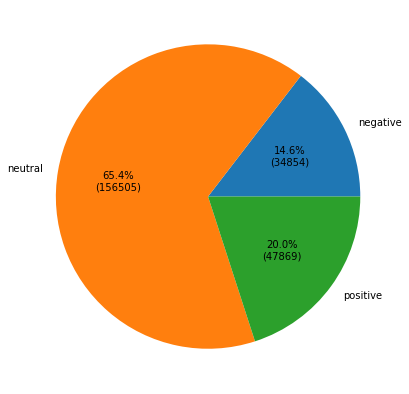

In [7]:
import matplotlib.pyplot as plt
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
one = p.count(1)
zero = p.count(0)
two = p.count(2)
fig = plt.figure(figsize =(10, 7))
plt.pie([zero,one,two], labels = ['negative','neutral','positive'], autopct = lambda pct: func(pct, [zero,one,two]))
plt.show()

In [8]:
# to split dataset into training and testing part
X = df['!'].astype('str')
y = p
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,test_size=0.1, random_state=42)
# 10% of the original dataset shall be used for testing purposes 
# stratify locks the distribution of different class labels. I.e. ratios of distribution of class labels in train and test will be almost same

In [9]:
# this is for tokenizing the words, then each word of the tokenized list shall be given a specific index 
tokenizer = Tokenizer(oov_token= '<0VV>') # <0VV> is the token that the model shall replace the unseen words with. So if some word of the test case is not there in tokenized list then that word shall be replaces with 0VV this is done to maintain the size of the sentence. 
tokenizer.fit_on_texts(X_train.astype(str)) # we have to use astype(str) as there are some numbers in df[!]
word_index_ = tokenizer.word_index # gives index to each word and then makes a dictionary of word and their indexes.


# since computer does not understand letters so we shall make list of sequence of numbers that is replaces sentences with sequences of indexes corresponding to those words that shall be feeded to our neural network model.
# the numbers that would constitue to this list are those numbers which are index of the corresponding words in the dictionary.
sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)


In [10]:
print(len(word_index_))

18078


In [11]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# different sentences has different length so we need to pad the sentences inorder to make all of them of same length before feeding them in our model
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_train = pad_sequences(sequence_train, maxlen= 52)
padded_test = pad_sequences(sequence_test, maxlen= 52)

In [13]:
type(padded_test)

numpy.ndarray

In [14]:
X_train = padded_train

X_test = padded_test
y_train = tf.keras.utils.to_categorical(y_train,num_classes= 3)
y_train

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

# Early stopping
To prevent overfitting of the model we shall be using early stopping. The corresponding callback function shall stop training when the validation accuracy does not increase for 3 consecutive epochs 

In [15]:
callback= tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3, verbose=2, mode="auto", restore_best_weights=True)
# patience counts number of epochs with no developement and then stops the epochs

In [16]:
# list to append all of the three models
a = []

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify = y_train ,test_size=0.1)

### Model 1

The sentences until now are just sequences of words and have no real meaning therefore we shall do word embedding to make sematic vectors. These vectors will be made by using the concept: meaning of the words is know by the company it has.

In [18]:
from keras.layers import LSTM
model1 = keras.models.Sequential()
model1.add(keras.layers.Embedding(18079+1, 52, input_length=52)) 
model1.add(LSTM(100))
model1.add(keras.layers.Dense(10, activation="relu"))
model1.add(keras.layers.Dense(3, activation="softmax")) 


In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 52)            940160    
                                                                 
 lstm (LSTM)                 (None, 100)               61200     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,002,403
Trainable params: 1,002,403
Non-trainable params: 0
_________________________________________________________________


In [20]:
model1.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.

verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar 

verbose=2 will just mention the number of epoch like this:

In [21]:
y_val.shape

(21531, 3)

In [22]:
#default batch size is 32
history = model1.fit(X_train, y_train, epochs = 8, verbose=2, validation_data=(X_val,y_val), callbacks = [callback]) # the validation data should be provied as tuple or less there is a huge error in format matching

Epoch 1/8
6056/6056 - 85s - loss: 0.5874 - accuracy: 0.7547 - val_loss: 0.5055 - val_accuracy: 0.7863 - 85s/epoch - 14ms/step
Epoch 2/8
6056/6056 - 75s - loss: 0.4555 - accuracy: 0.8089 - val_loss: 0.4787 - val_accuracy: 0.7986 - 75s/epoch - 12ms/step
Epoch 3/8
6056/6056 - 74s - loss: 0.4060 - accuracy: 0.8276 - val_loss: 0.4717 - val_accuracy: 0.8073 - 74s/epoch - 12ms/step
Epoch 4/8
6056/6056 - 74s - loss: 0.3713 - accuracy: 0.8420 - val_loss: 0.4754 - val_accuracy: 0.8076 - 74s/epoch - 12ms/step
Epoch 5/8
6056/6056 - 73s - loss: 0.3453 - accuracy: 0.8523 - val_loss: 0.4860 - val_accuracy: 0.8054 - 73s/epoch - 12ms/step
Epoch 6/8
6056/6056 - 74s - loss: 0.3234 - accuracy: 0.8603 - val_loss: 0.4974 - val_accuracy: 0.8060 - 74s/epoch - 12ms/step
Epoch 7/8
Restoring model weights from the end of the best epoch: 4.
6056/6056 - 75s - loss: 0.3030 - accuracy: 0.8684 - val_loss: 0.5262 - val_accuracy: 0.8042 - 75s/epoch - 12ms/step
Epoch 7: early stopping


In [23]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes= 3)
print(y_test.shape, X_test.shape)

(23924, 3) (23924, 52)


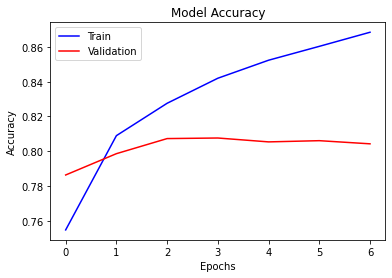

In [24]:
# to plot the graph of accuracy vs epochs
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Since now our model is trianed so we shall find it's actuall accuracy. For doing that we shall pass unseen data into the model and then check the corresponing accuracy. The unseen data in this case is the test data. 

In [25]:
scores = model1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8047567009925842


In [26]:
model1.save('model1.h5')

In [27]:
a.append(model1)

### Model2

In [28]:
from keras.layers import LSTM
from keras.layers import Bidirectional, Dense
model2 = keras.models.Sequential()
model2.add(keras.layers.Embedding(18079+1, 52, input_length=52))
model2.add(Bidirectional(LSTM(52)))
model2.add(keras.layers.Dense(10, activation="relu"))
model2.add(keras.layers.Dense(3, activation="softmax"))

In [29]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 52, 52)            940160    
                                                                 
 bidirectional (Bidirectiona  (None, 104)              43680     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 10)                1050      
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 984,923
Trainable params: 984,923
Non-trainable params: 0
_________________________________________________________________


In [30]:
model2.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
print(X_train.shape, y_train.shape)

(193776, 52) (193776, 3)


In [32]:
x = model2.fit(X_train, y_train, epochs = 8, verbose=2, validation_data=(X_val,y_val), callbacks = [callback])


Epoch 1/8
6056/6056 - 153s - loss: 0.5896 - accuracy: 0.7561 - val_loss: 0.4988 - val_accuracy: 0.7912 - 153s/epoch - 25ms/step
Epoch 2/8
6056/6056 - 148s - loss: 0.4482 - accuracy: 0.8120 - val_loss: 0.4747 - val_accuracy: 0.8014 - 148s/epoch - 24ms/step
Epoch 3/8
6056/6056 - 148s - loss: 0.3986 - accuracy: 0.8313 - val_loss: 0.4726 - val_accuracy: 0.8062 - 148s/epoch - 24ms/step
Epoch 4/8
6056/6056 - 148s - loss: 0.3657 - accuracy: 0.8444 - val_loss: 0.4843 - val_accuracy: 0.8045 - 148s/epoch - 24ms/step
Epoch 5/8
6056/6056 - 148s - loss: 0.3405 - accuracy: 0.8539 - val_loss: 0.4944 - val_accuracy: 0.8067 - 148s/epoch - 24ms/step
Epoch 6/8
6056/6056 - 148s - loss: 0.3186 - accuracy: 0.8623 - val_loss: 0.5090 - val_accuracy: 0.8030 - 148s/epoch - 24ms/step
Epoch 7/8
6056/6056 - 149s - loss: 0.2991 - accuracy: 0.8690 - val_loss: 0.5331 - val_accuracy: 0.8004 - 149s/epoch - 25ms/step
Epoch 8/8
Restoring model weights from the end of the best epoch: 5.
6056/6056 - 152s - loss: 0.2806 - a

In [33]:
print(X_test.shape,y_test.shape)

(23924, 52) (23924, 3)


In [34]:
scores = model2.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', scores[1])

748/748 - 7s - loss: 0.4957 - accuracy: 0.8041 - 7s/epoch - 9ms/step
Test accuracy: 0.8041297197341919


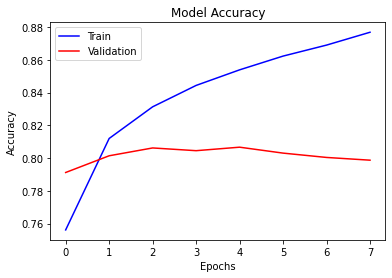

In [35]:
history = x
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
model2.save('model2.h5')

In [37]:
a.append(model2)

### Model3

In [38]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Embedding(18079+1, 52, input_length=52))
model3.add(keras.layers.GlobalAveragePooling1D())
model3.add(keras.layers.Dense(30, activation="relu"))
model3.add(keras.layers.Dense(10, activation="relu"))
model3.add(keras.layers.Dense(3, activation="softmax"))

In [39]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 52, 52)            940160    
                                                                 
 global_average_pooling1d (G  (None, 52)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 30)                1590      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
 dense_6 (Dense)             (None, 3)                 33        
                                                                 
Total params: 942,093
Trainable params: 942,093
Non-trainable params: 0
________________________________________________

In [40]:
model3.compile(loss= "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [41]:
print(X_train.shape, y_train.shape)

(193776, 52) (193776, 3)


In [42]:
x = model3.fit(X_train, y_train, epochs = 8, verbose=2, validation_data=(X_val,y_val), callbacks = [callback])

Epoch 1/8
6056/6056 - 33s - loss: 0.7162 - accuracy: 0.7143 - val_loss: 0.5472 - val_accuracy: 0.7768 - 33s/epoch - 5ms/step
Epoch 2/8
6056/6056 - 32s - loss: 0.5048 - accuracy: 0.7943 - val_loss: 0.5157 - val_accuracy: 0.7882 - 32s/epoch - 5ms/step
Epoch 3/8
6056/6056 - 32s - loss: 0.4651 - accuracy: 0.8088 - val_loss: 0.5191 - val_accuracy: 0.7860 - 32s/epoch - 5ms/step
Epoch 4/8
6056/6056 - 31s - loss: 0.4428 - accuracy: 0.8169 - val_loss: 0.5082 - val_accuracy: 0.7928 - 31s/epoch - 5ms/step
Epoch 5/8
6056/6056 - 31s - loss: 0.4257 - accuracy: 0.8232 - val_loss: 0.5029 - val_accuracy: 0.7963 - 31s/epoch - 5ms/step
Epoch 6/8
6056/6056 - 32s - loss: 0.4119 - accuracy: 0.8288 - val_loss: 0.5022 - val_accuracy: 0.7993 - 32s/epoch - 5ms/step
Epoch 7/8
6056/6056 - 31s - loss: 0.3984 - accuracy: 0.8338 - val_loss: 0.5103 - val_accuracy: 0.7987 - 31s/epoch - 5ms/step
Epoch 8/8
6056/6056 - 32s - loss: 0.3869 - accuracy: 0.8386 - val_loss: 0.5090 - val_accuracy: 0.7975 - 32s/epoch - 5ms/step


In [43]:
scores = model3.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', scores[1])

748/748 - 2s - loss: 0.5089 - accuracy: 0.7985 - 2s/epoch - 2ms/step
Test accuracy: 0.7985286712646484


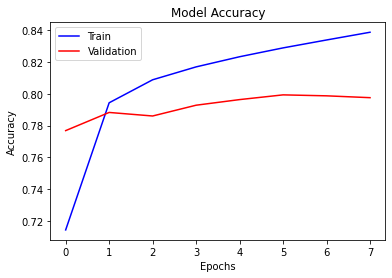

In [44]:
history = x
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
model3.save('model3.h5')

In [46]:
a.append(model3)

# Integrated Stacking 
In this case we shall be using neural networks as meta-learner for three sub-models that is LSTM, Feed forward neural network and bidirection LSTM.
Integrated Stacking is basically a way of aggregating all the prdictions of the preditors in an ensemble using deep neural nets. The output predictions of all the submodels are used as input for the meta-learner.
By doing this the accuracy of the final models increase. 
  


In [47]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import plot_model

In [48]:
def stacked_model(members):
	# here we don't want to upload the weights of our already pretrained model so we have to upadte all layers in all models to not be trainable.
  #print(members)
  for i in range(len(members)):
    model = members[i]
    for layer in model.layers:
      layer.trainable = False
			
	# define multi-headed input
  ensemble_visible = [model.input for model in members]
  # concatenate merge output from each model
  ensemble_outputs = [model.output for model in members]
  merge = Concatenate()(ensemble_outputs)

  hidden = keras.layers.Dense(7, activation='relu')(merge)
  output = keras.layers.Dense(3, activation='softmax')(hidden)
  model = tf.keras.Model(inputs=ensemble_visible, outputs=output)
  plot_model(model, show_shapes=True, to_file='model.png')

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

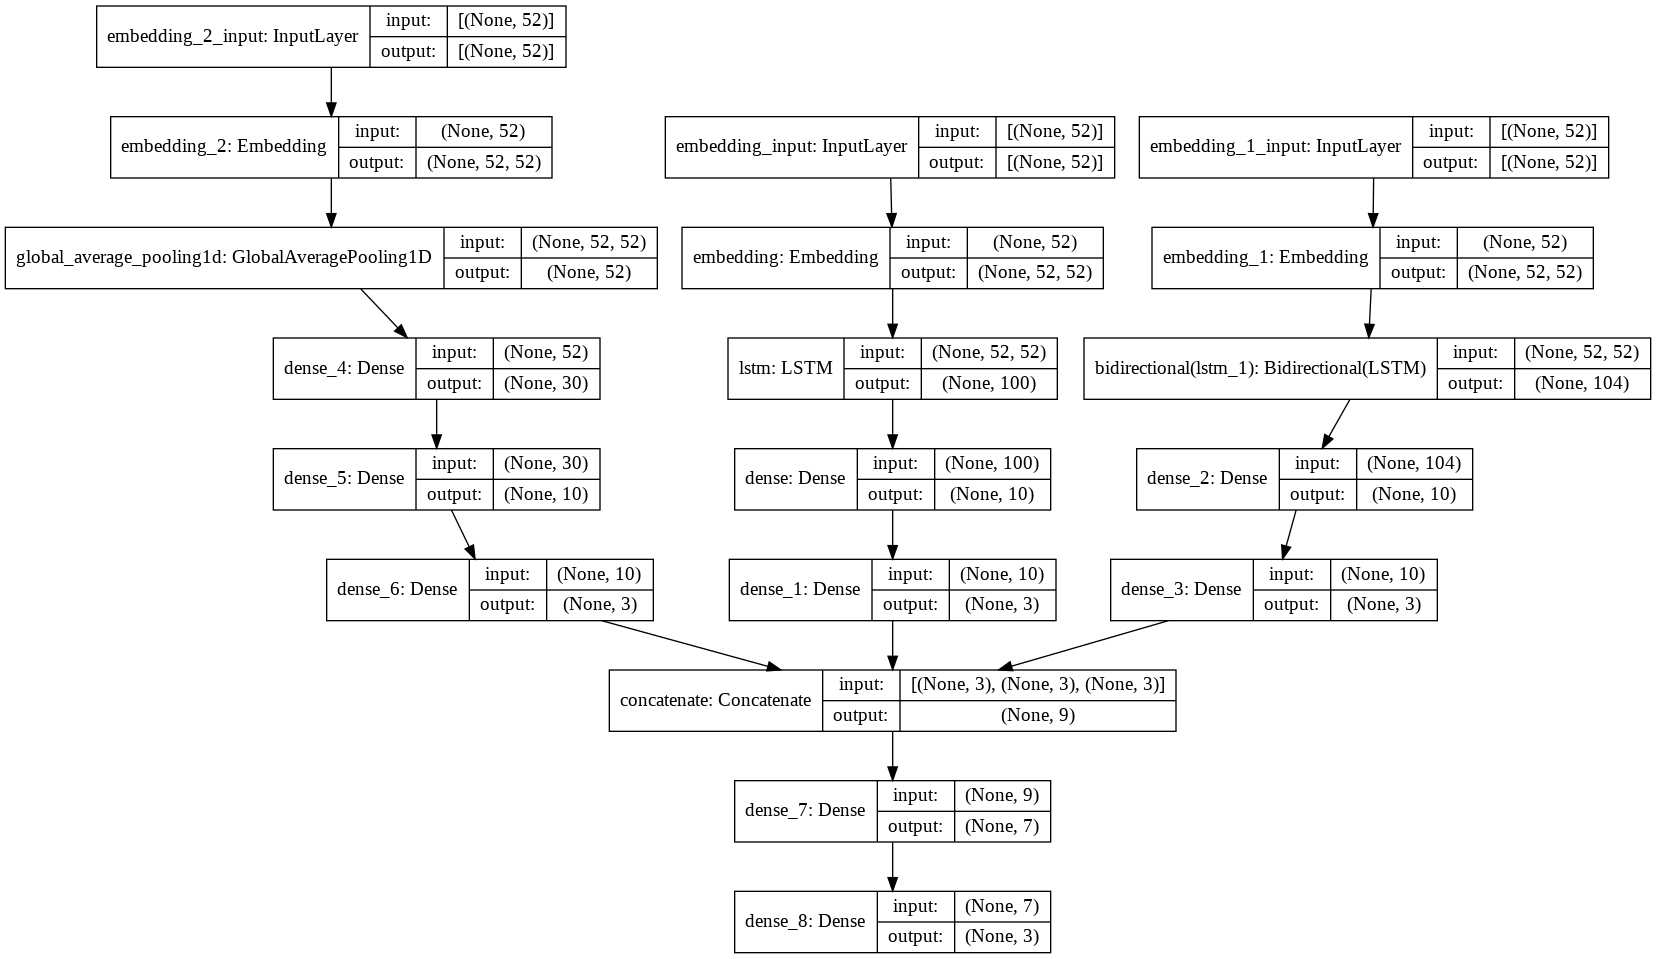

In [49]:
final_model = stacked_model(a)

In [50]:
final_model.input

[<KerasTensor: shape=(None, 52) dtype=float32 (created by layer 'embedding_input')>,
 <KerasTensor: shape=(None, 52) dtype=float32 (created by layer 'embedding_1_input')>,
 <KerasTensor: shape=(None, 52) dtype=float32 (created by layer 'embedding_2_input')>]

In [51]:
type(stacked_model)

function

In [52]:
histoy = final_model.fit([X_val,X_val,X_val], y_val,epochs = 3, verbose = 2,validation_split=0.1)

Epoch 1/3
606/606 - 17s - loss: 0.6007 - accuracy: 0.8049 - val_loss: 0.4771 - val_accuracy: 0.8134 - 17s/epoch - 27ms/step
Epoch 2/3
606/606 - 10s - loss: 0.4751 - accuracy: 0.8114 - val_loss: 0.4676 - val_accuracy: 0.8097 - 10s/epoch - 16ms/step
Epoch 3/3
606/606 - 10s - loss: 0.4695 - accuracy: 0.8101 - val_loss: 0.4632 - val_accuracy: 0.8097 - 10s/epoch - 16ms/step


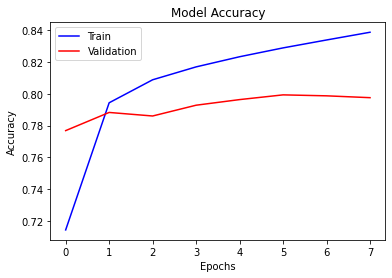

In [53]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy'),
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:
Scoree = final_model.evaluate([X_test,X_test,X_test],y_test,verbose = 2)
print(Scoree[1])


748/748 - 11s - loss: 0.4653 - accuracy: 0.8101 - 11s/epoch - 15ms/step
0.8101487755775452


## Entre a sentence to see the sentiment of that sentences




In [68]:
o = "It is having the most Incompetant and political organisation which has nothing to do with student future."
sequence = tokenizer.texts_to_sequences([o])
test = pad_sequences(sequence, maxlen=52)
sentiment = ['Negative','Neutral','Positive']
print(test)


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   10    8  606    2   49    1    5
   434    1   93   40  152    6   72   13 2459  549]]


In [69]:
sentiment[np.around(model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [70]:
model2.predict(test)

array([[0.8220993 , 0.17355882, 0.00434188]], dtype=float32)

In [71]:
model3.predict(test)

array([[0.53198975, 0.43798885, 0.03002135]], dtype=float32)

In [72]:
model1.predict(test)

array([[0.73986137, 0.2558831 , 0.0042556 ]], dtype=float32)

In [73]:
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

In [74]:
yhat = predict_stacked_model(final_model, test)
print(yhat)
sentiment[np.around(yhat, decimals=0).argmax(axis=1)[0]]


[[0.68309444 0.3083176  0.00858802]]


'Negative'

# i.e. the overall accuracy of the ensembled model is approximately 1% more than the best model of three submodels(the bidirectional LSTM)

In [62]:
final_model.save('deepverse.h5')